In [1]:
import os
import pandas
import matplotlib.pyplot as plt
import seaborn
from tqdm import tqdm
import numpy as np

import torch
from torch import nn
from torch.optim import Adam
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import CelebA
from torchvision import transforms
import torchvision.transforms.functional as F
from torchvision.utils import make_grid

plt.rcParams["savefig.bbox"] = 'tight'

In [2]:
class CNN_CelebA(nn.Module):
    def __init__(self):
        super(CNN_CelebA, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size= 3, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(),
            nn.Conv2d(32, 64, kernel_size= 3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            nn.Conv2d(64, 128, kernel_size= 3, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(),
            nn.Conv2d(128, 256, kernel_size= 3, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(),
            nn.Conv2d(256, 512, kernel_size= 3, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(),
            nn.Flatten()
        )

        self.z_mean = nn.Linear(512*4, 128)
        self.z_log_var = nn.Linear(512*4, 128)

        self.decoder = nn.Sequential(
            nn.Linear(128, 512*4),
            nn.Unflatten(1, (512, 2, 2)),
            nn.ConvTranspose2d(512, 256, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(),            
            nn.ConvTranspose2d(32, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(),
            nn.Conv2d(32, 3, kernel_size= 3, padding= 1),
            nn.Tanh()
        )

    def forward(self, x):
        enc = self.encoder(x)
        mu = self.z_mean(enc)
        lv = self.z_log_var(enc)
        lat = self.reparam(mu, lv)
        dec = self.decoder(lat)
        
        return dec, mu, lv

    def reparam(self, mu, lv):
        std = torch.exp(0.5 * lv)
        eps = torch.randn_like(std)
        return mu + std * eps

    def get_latent(self, x):
        enc = self.encoder(x)
        mu = self.z_mean(enc)
        lv = self.z_log_var(enc)
        lat = self.reparam(mu, lv)

        return lat

In [3]:
transform = transforms.Compose(
    [
        transforms.RandomHorizontalFlip(),
        transforms.CenterCrop(148),
        transforms.Resize(64),
        transforms.ToTensor()
    ]
)

root_dir = '/media/mountHDD2/data'

trainset = CelebA(root=root_dir, split='train', download=True, transform=transform)
train_dl = DataLoader(trainset, batch_size=64, shuffle=True, num_workers=24)
validset = CelebA(root=root_dir, split='valid', download=True, transform=transform)
valid_dl = DataLoader(validset, batch_size=64, shuffle=False, num_workers=24)
testset = CelebA(root=root_dir, split='test', download=True, transform=transform)
test_dl = DataLoader(testset, batch_size=64, shuffle=False, num_workers=24)

print(len(trainset), len(validset), len(testset))
print(len(train_dl), len(valid_dl), len(test_dl))

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
162770 19867 19962
2544 311 312


In [4]:
def gaussian_kls(mu, logvar):
    kld_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp(), dim=1)
    return torch.mean(kld_loss)

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu", index = 0)

model = CNN_CelebA().to(device)

optimizer = Adam(params = model.parameters(), lr = 0.005)

epochs = 30

scheduler = CosineAnnealingLR(optimizer, epochs*len(train_dl))

recon_loss = nn.MSELoss(reduction='none')

def loss_fn(recon_x, x):
    return torch.mean(torch.sum(recon_loss(recon_x, x), dim=(1,2,3)))

In [6]:
for epoch in range(epochs):
    model.train()
    tr_total_loss = {
        "rec_loss" : 0,
        "kl_loss" : 0
    }
    for train_img, _ in tqdm(train_dl):
        train_img = train_img.to(device)

        gen_img, train_mu, train_lv = model(train_img)
        train_rec_loss = loss_fn(gen_img, train_img)
        train_kl_loss = gaussian_kls(train_mu, train_lv)
        train_loss = train_rec_loss + train_kl_loss

        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()

        scheduler.step()

        tr_total_loss["rec_loss"] += train_rec_loss.item()
        tr_total_loss["kl_loss"] += train_kl_loss.item()

    model.eval()
    with torch.no_grad():
        va_total_loss = {
            "rec_loss" : 0,
            "kl_loss" : 0
        }
        for valid_img, _ in tqdm(test_dl):
            valid_img = valid_img.to(device)

            gen_img, valid_mu, valid_lv = model(valid_img)
            valid_rec_loss = loss_fn(gen_img, valid_img)
            valid_kl_loss = gaussian_kls(valid_mu, valid_lv)
            valid_loss = valid_rec_loss + valid_kl_loss

            va_total_loss["rec_loss"] += valid_rec_loss.item()
            va_total_loss["kl_loss"] += valid_kl_loss.item()

    print(f"Epoch: {epoch} - TrainRecLoss: {tr_total_loss['rec_loss']/len(train_dl)} - ValidRecLoss: {va_total_loss['rec_loss']/len(test_dl)}")
    print(f"Epoch: {epoch} - TrainDivLoss: {tr_total_loss['kl_loss']/len(train_dl)} - ValidDivLoss: {va_total_loss['kl_loss']/len(test_dl)}")

100%|█████████████████████████████████████████████████████████████████| 312/312 [00:02<00:00, 123.29it/s]


Epoch: 0 - TrainRecLoss: 248.5129407426846 - ValidRecLoss: 155.9341587653527
Epoch: 0 - TrainDivLoss: 43.31033809080064 - ValidDivLoss: 43.037522413791756


100%|█████████████████████████████████████████████████████████████████| 312/312 [00:02<00:00, 124.58it/s]


Epoch: 1 - TrainRecLoss: 151.29808448695536 - ValidRecLoss: 138.41445556053748
Epoch: 1 - TrainDivLoss: 45.790757900513945 - ValidDivLoss: 46.61316119707548


100%|█████████████████████████████████████████████████████████████████| 312/312 [00:02<00:00, 119.71it/s]


Epoch: 2 - TrainRecLoss: 138.96731408437094 - ValidRecLoss: 129.87853536850366
Epoch: 2 - TrainDivLoss: 48.319716784939075 - ValidDivLoss: 49.89843880824554


100%|█████████████████████████████████████████████████████████████████| 312/312 [00:02<00:00, 121.38it/s]


Epoch: 3 - TrainRecLoss: 132.6028497533978 - ValidRecLoss: 125.07213101020226
Epoch: 3 - TrainDivLoss: 49.85777954485432 - ValidDivLoss: 50.40935939397567


100%|█████████████████████████████████████████████████████████████████| 312/312 [00:02<00:00, 122.01it/s]


Epoch: 4 - TrainRecLoss: 127.77431637386105 - ValidRecLoss: 123.96982327485696
Epoch: 4 - TrainDivLoss: 50.98755975189449 - ValidDivLoss: 50.4127919123723


100%|█████████████████████████████████████████████████████████████████| 312/312 [00:02<00:00, 123.49it/s]


Epoch: 5 - TrainRecLoss: 124.23221665208445 - ValidRecLoss: 118.4854434820322
Epoch: 5 - TrainDivLoss: 51.753017343065274 - ValidDivLoss: 51.724724769592285


100%|█████████████████████████████████████████████████████████████████| 312/312 [00:02<00:00, 120.24it/s]


Epoch: 6 - TrainRecLoss: 121.80713601982069 - ValidRecLoss: 116.97820303990291
Epoch: 6 - TrainDivLoss: 52.337407256072424 - ValidDivLoss: 52.89712367913662


100%|█████████████████████████████████████████████████████████████████| 312/312 [00:02<00:00, 122.81it/s]


Epoch: 7 - TrainRecLoss: 119.67911501350643 - ValidRecLoss: 116.19777598747841
Epoch: 7 - TrainDivLoss: 52.696169818722225 - ValidDivLoss: 51.70701338694646


100%|█████████████████████████████████████████████████████████████████| 312/312 [00:02<00:00, 118.57it/s]


Epoch: 8 - TrainRecLoss: 118.17712283584306 - ValidRecLoss: 115.44407658699231
Epoch: 8 - TrainDivLoss: 52.94465722527894 - ValidDivLoss: 52.354910153609055


100%|█████████████████████████████████████████████████████████████████| 312/312 [00:02<00:00, 121.88it/s]


Epoch: 9 - TrainRecLoss: 116.85959723610549 - ValidRecLoss: 112.96572025005634
Epoch: 9 - TrainDivLoss: 53.16327827831484 - ValidDivLoss: 53.40484324479714


100%|█████████████████████████████████████████████████████████████████| 312/312 [00:02<00:00, 121.19it/s]


Epoch: 10 - TrainRecLoss: 115.86707742858982 - ValidRecLoss: 113.13921057872282
Epoch: 10 - TrainDivLoss: 53.334630981181405 - ValidDivLoss: 52.53551145700308


100%|█████████████████████████████████████████████████████████████████| 312/312 [00:02<00:00, 120.12it/s]


Epoch: 11 - TrainRecLoss: 114.72811140804171 - ValidRecLoss: 110.80742735740466
Epoch: 11 - TrainDivLoss: 53.52312086963054 - ValidDivLoss: 53.860140189146385


100%|█████████████████████████████████████████████████████████████████| 312/312 [00:02<00:00, 113.97it/s]


Epoch: 12 - TrainRecLoss: 113.79085383025355 - ValidRecLoss: 110.19169134971423
Epoch: 12 - TrainDivLoss: 53.63695039689166 - ValidDivLoss: 53.46124850786649


100%|█████████████████████████████████████████████████████████████████| 312/312 [00:02<00:00, 122.41it/s]


Epoch: 13 - TrainRecLoss: 112.86019394832587 - ValidRecLoss: 109.92662872412266
Epoch: 13 - TrainDivLoss: 53.71675289351985 - ValidDivLoss: 53.19040061265994


100%|█████████████████████████████████████████████████████████████████| 312/312 [00:02<00:00, 118.80it/s]


Epoch: 14 - TrainRecLoss: 112.13902423666708 - ValidRecLoss: 109.1007817586263
Epoch: 14 - TrainDivLoss: 53.86250392146081 - ValidDivLoss: 53.32631179613945


100%|█████████████████████████████████████████████████████████████████| 312/312 [00:02<00:00, 121.09it/s]


Epoch: 15 - TrainRecLoss: 111.27281905720069 - ValidRecLoss: 108.73889585641714
Epoch: 15 - TrainDivLoss: 53.95723951687603 - ValidDivLoss: 53.50938822672917


100%|█████████████████████████████████████████████████████████████████| 312/312 [00:02<00:00, 116.26it/s]


Epoch: 16 - TrainRecLoss: 110.55617519294691 - ValidRecLoss: 108.07130529941657
Epoch: 16 - TrainDivLoss: 54.02550170106708 - ValidDivLoss: 54.002921654627876


100%|█████████████████████████████████████████████████████████████████| 312/312 [00:02<00:00, 121.60it/s]


Epoch: 17 - TrainRecLoss: 109.98781268401716 - ValidRecLoss: 107.60773164798051
Epoch: 17 - TrainDivLoss: 54.11530673728799 - ValidDivLoss: 53.515922925411125


100%|█████████████████████████████████████████████████████████████████| 312/312 [00:02<00:00, 120.77it/s]


Epoch: 18 - TrainRecLoss: 109.34579758674094 - ValidRecLoss: 106.70613655677208
Epoch: 18 - TrainDivLoss: 54.211659602399145 - ValidDivLoss: 53.62774264506805


100%|█████████████████████████████████████████████████████████████████| 312/312 [00:02<00:00, 120.12it/s]


Epoch: 19 - TrainRecLoss: 108.78916108533271 - ValidRecLoss: 106.9950160246629
Epoch: 19 - TrainDivLoss: 54.23604300636915 - ValidDivLoss: 53.463239229642426


100%|█████████████████████████████████████████████████████████████████| 312/312 [00:02<00:00, 116.17it/s]


Epoch: 20 - TrainRecLoss: 108.28485091227405 - ValidRecLoss: 106.42020196181078
Epoch: 20 - TrainDivLoss: 54.338474551086904 - ValidDivLoss: 53.39407231257512


100%|█████████████████████████████████████████████████████████████████| 312/312 [00:02<00:00, 122.83it/s]


Epoch: 21 - TrainRecLoss: 107.79973021993098 - ValidRecLoss: 106.05738811003856
Epoch: 21 - TrainDivLoss: 54.32667617078097 - ValidDivLoss: 53.83213516382071


100%|█████████████████████████████████████████████████████████████████| 312/312 [00:02<00:00, 118.90it/s]


Epoch: 22 - TrainRecLoss: 107.36032079000893 - ValidRecLoss: 105.44224900465746
Epoch: 22 - TrainDivLoss: 54.37283888253026 - ValidDivLoss: 53.72396315061129


100%|█████████████████████████████████████████████████████████████████| 312/312 [00:02<00:00, 122.29it/s]


Epoch: 23 - TrainRecLoss: 107.00397755964747 - ValidRecLoss: 105.2111463546753
Epoch: 23 - TrainDivLoss: 54.44742621265867 - ValidDivLoss: 53.96559048921634


100%|█████████████████████████████████████████████████████████████████| 312/312 [00:02<00:00, 122.10it/s]


Epoch: 24 - TrainRecLoss: 106.74416930720491 - ValidRecLoss: 105.10245398986034
Epoch: 24 - TrainDivLoss: 54.45618116780647 - ValidDivLoss: 53.927617574349426


100%|█████████████████████████████████████████████████████████████████| 312/312 [00:02<00:00, 117.17it/s]


Epoch: 25 - TrainRecLoss: 106.43454075759311 - ValidRecLoss: 104.54569259056679
Epoch: 25 - TrainDivLoss: 54.49201673081836 - ValidDivLoss: 53.97231427217141


100%|█████████████████████████████████████████████████████████████████| 312/312 [00:02<00:00, 121.62it/s]


Epoch: 26 - TrainRecLoss: 106.21305835172065 - ValidRecLoss: 104.50274956532014
Epoch: 26 - TrainDivLoss: 54.50431353940904 - ValidDivLoss: 54.03885012406569


100%|█████████████████████████████████████████████████████████████████| 312/312 [00:02<00:00, 120.21it/s]


Epoch: 27 - TrainRecLoss: 106.07315866602292 - ValidRecLoss: 104.6181975878202
Epoch: 27 - TrainDivLoss: 54.49853860057375 - ValidDivLoss: 53.693722260303986


100%|█████████████████████████████████████████████████████████████████| 312/312 [00:02<00:00, 122.44it/s]


Epoch: 28 - TrainRecLoss: 105.94669137210965 - ValidRecLoss: 104.77828822991786
Epoch: 28 - TrainDivLoss: 54.5048589946339 - ValidDivLoss: 53.623250716771835


100%|█████████████████████████████████████████████████████████████████| 312/312 [00:02<00:00, 122.18it/s]

Epoch: 29 - TrainRecLoss: 105.8971150956064 - ValidRecLoss: 104.45999837533022
Epoch: 29 - TrainDivLoss: 54.48157236561085 - ValidDivLoss: 53.90894838479849


In [7]:
def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fig, axs = plt.subplots(ncols=len(imgs), squeeze=False, figsize=(40, 40))
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

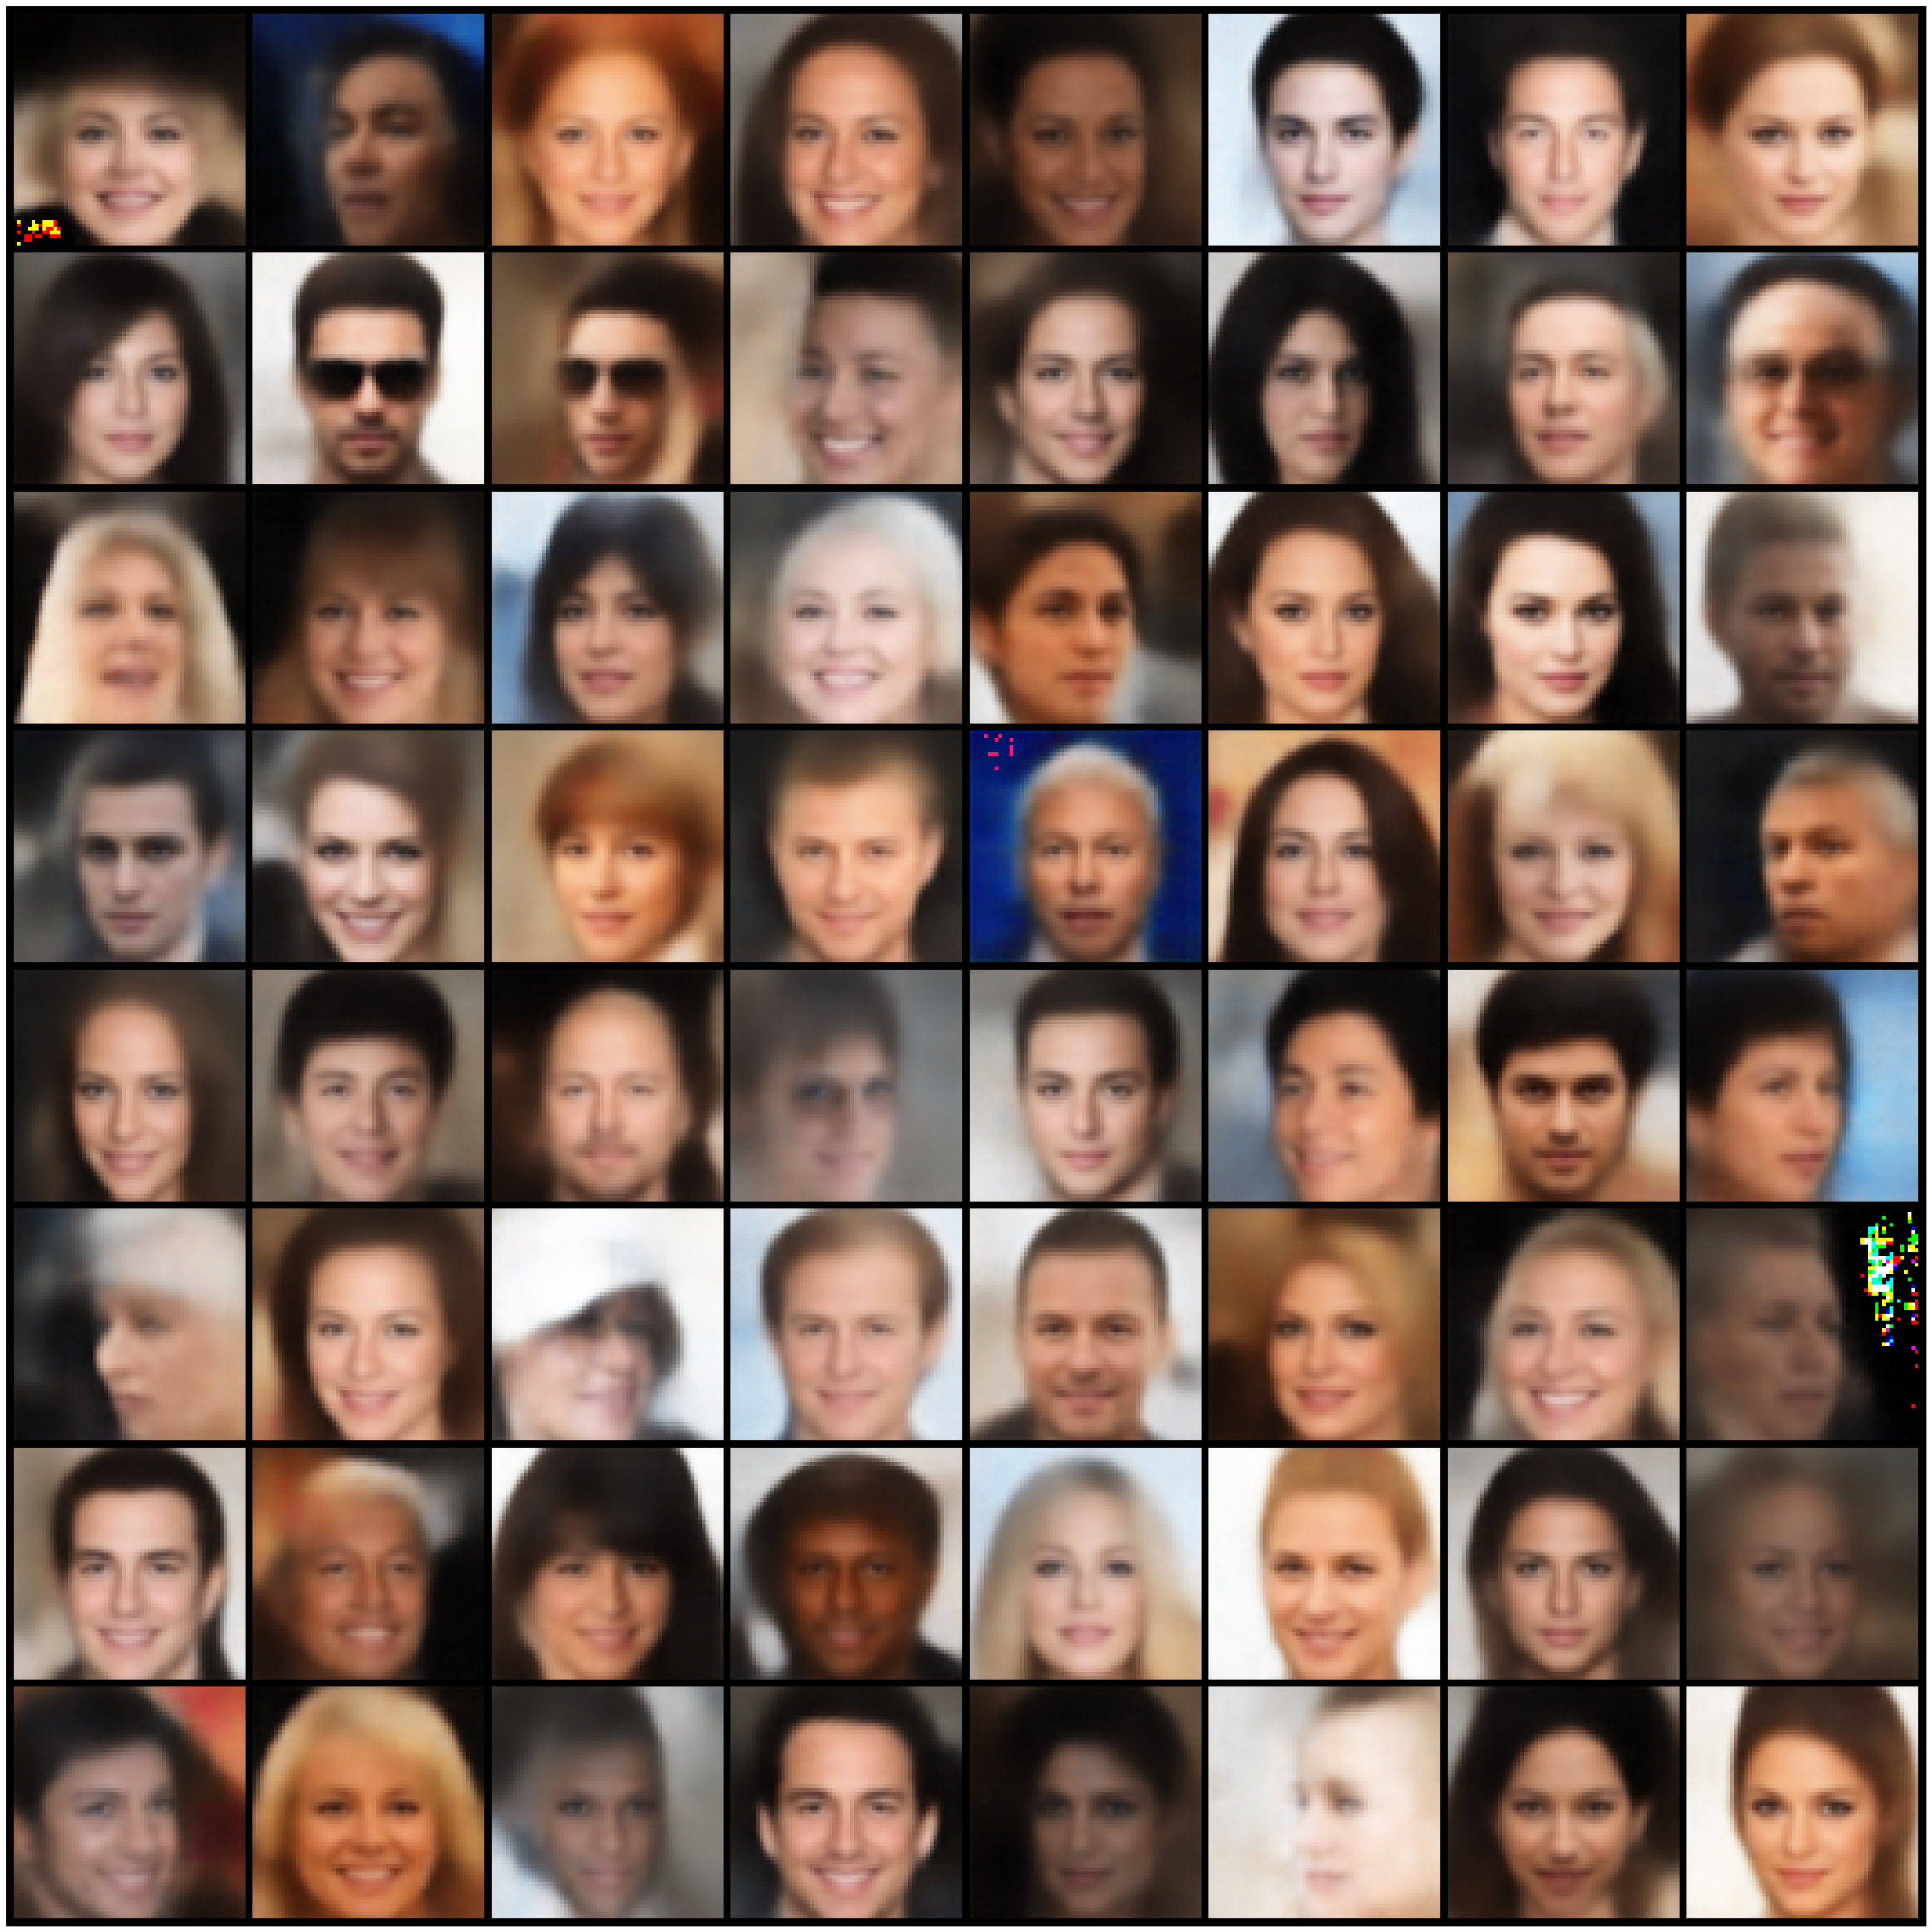

In [8]:
test_input, _ = next(iter(test_dl))
test_input = test_input.to(device)

model.eval()
with torch.no_grad():
    recons, _, _ = model(test_input)

grid = make_grid(recons)
show(grid)

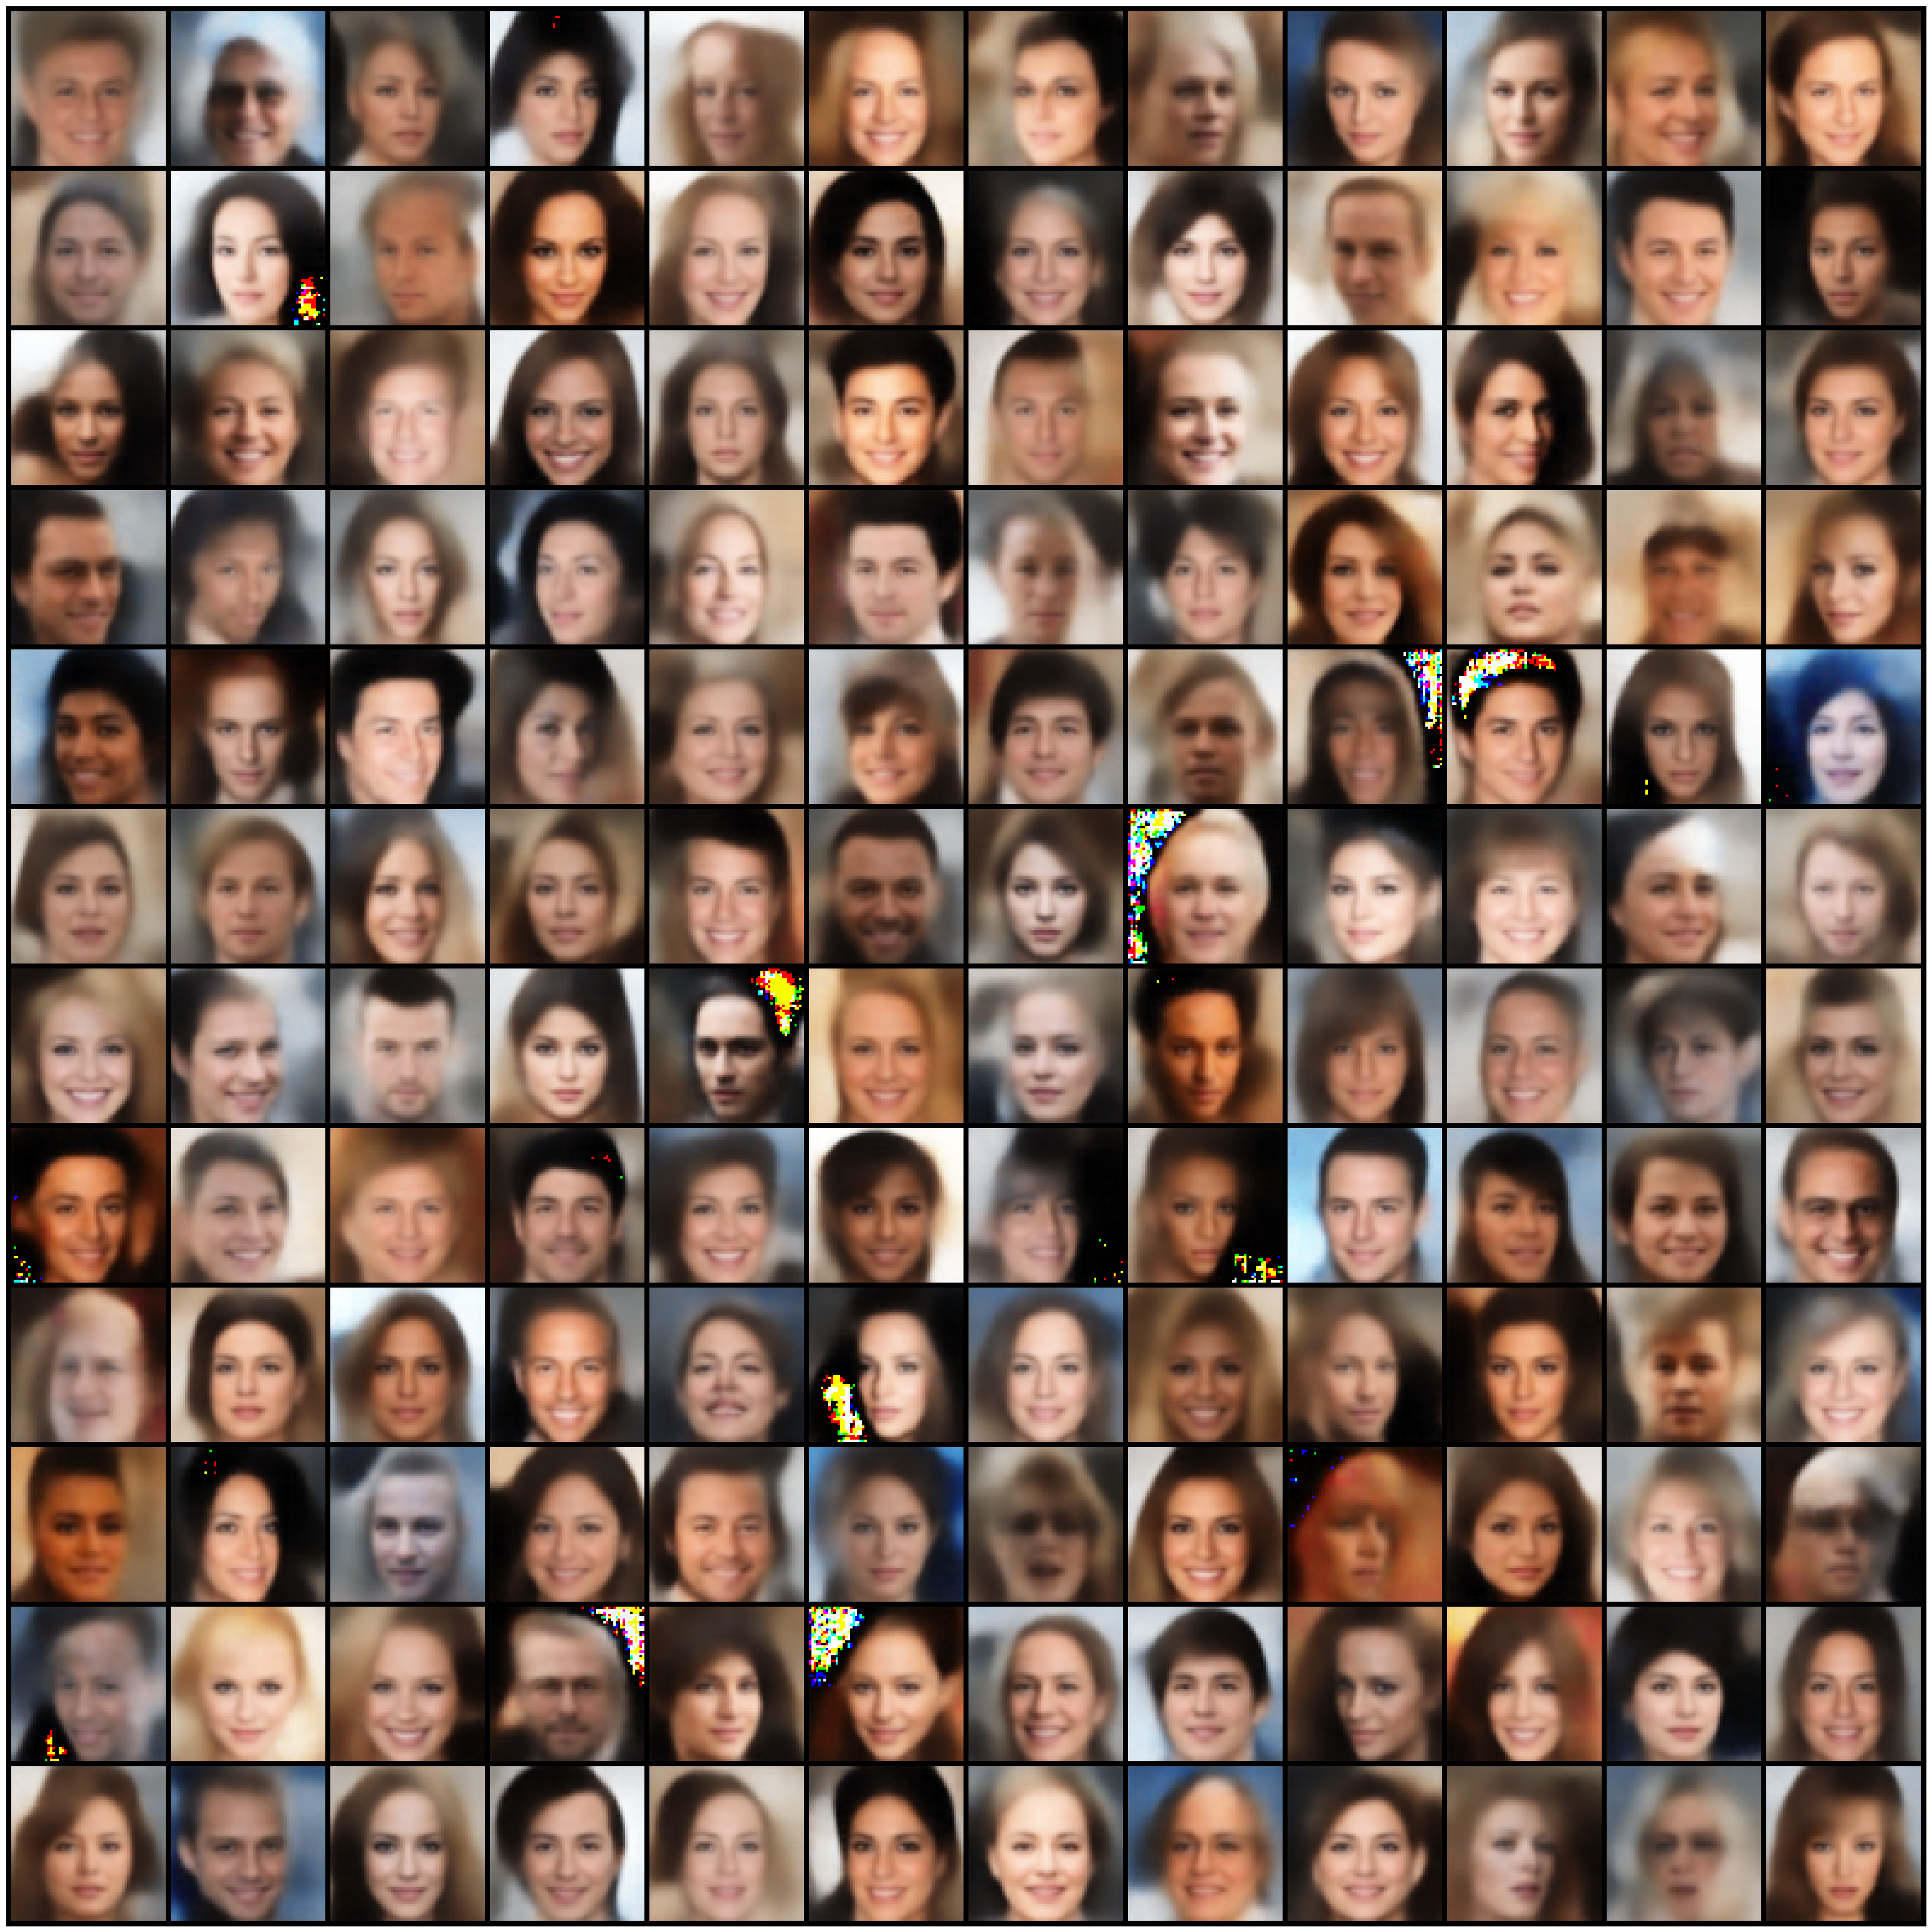

In [9]:
z = torch.randn(144, 128).to(device)

samples = model.decoder(z)

grid = make_grid(samples, nrow=12)
show(grid)

In [10]:
attrs = trainset.attr_names[:-1]
print(attrs)
print(f"#Attr: {len(attrs)}")

['5_o_Clock_Shadow', 'Arched_Eyebrows', 'Attractive', 'Bags_Under_Eyes', 'Bald', 'Bangs', 'Big_Lips', 'Big_Nose', 'Black_Hair', 'Blond_Hair', 'Blurry', 'Brown_Hair', 'Bushy_Eyebrows', 'Chubby', 'Double_Chin', 'Eyeglasses', 'Goatee', 'Gray_Hair', 'Heavy_Makeup', 'High_Cheekbones', 'Male', 'Mouth_Slightly_Open', 'Mustache', 'Narrow_Eyes', 'No_Beard', 'Oval_Face', 'Pale_Skin', 'Pointy_Nose', 'Receding_Hairline', 'Rosy_Cheeks', 'Sideburns', 'Smiling', 'Straight_Hair', 'Wavy_Hair', 'Wearing_Earrings', 'Wearing_Hat', 'Wearing_Lipstick', 'Wearing_Necklace', 'Wearing_Necktie', 'Young']
#Attr: 40


In [12]:
def interpolate(autoencoder, x_1, x_2, n=20, title=None):
    z_1 = autoencoder.get_latent(x_1)[0]
    z_2 = autoencoder.get_latent(x_2)[0]
    z = torch.stack([z_1 + (z_2 - z_1)*t for t in np.linspace(0, 1, n)])
    interpolate_list = autoencoder.decoder(z)
    interpolate_list = interpolate_list.permute(0, 2, 3, 1).to('cpu').detach().numpy()

    w = 64
    img = np.zeros((w, n*w, 3))
    for i, x_hat in enumerate(interpolate_list):
        img[:, i*w:(i+1)*w] = x_hat
    fig, ax = plt.subplots(figsize=(15, 2))
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
    plt.title(title)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


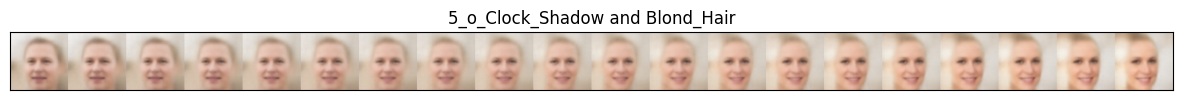

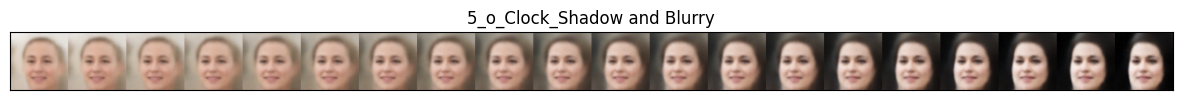

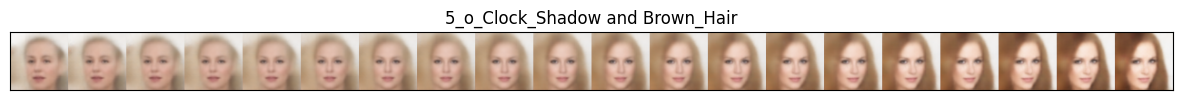

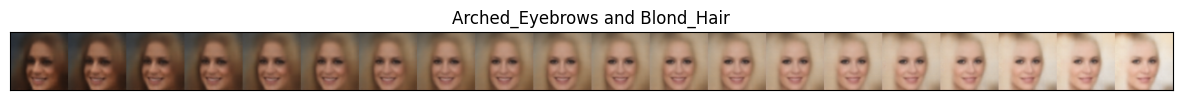

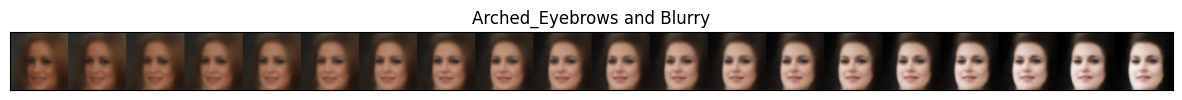

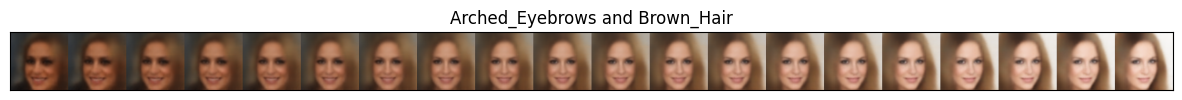

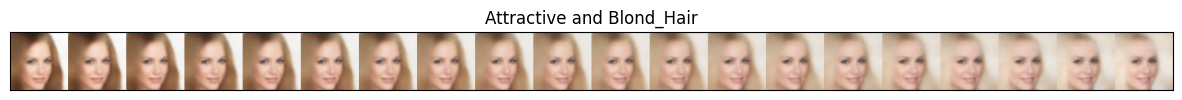

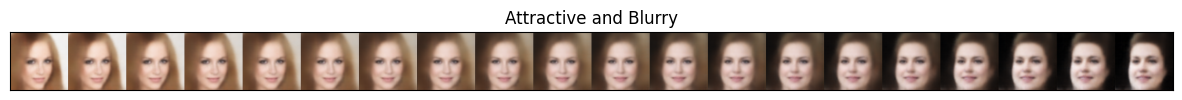

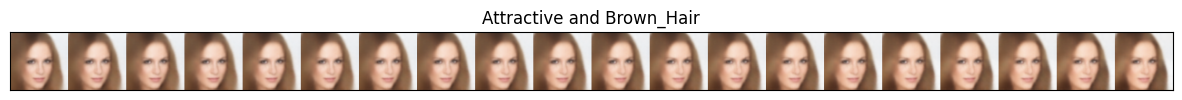

In [14]:
model.eval()
with torch.no_grad():
    x, y = next(iter(train_dl))
    for idx_x in range(3):
        for idx_y in range(9, 12):
            x_1 = x[y[:, idx_x] == 1][1].to(device).unsqueeze(0)
            x_2 = x[y[:, idx_y] == 1][1].to(device).unsqueeze(0)

            interpolate(model, x_1, x_2, n=20, title = f"{attrs[idx_x]} and {attrs[idx_y]}")

            # plt.close()